In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import celloracle as co
import anndata as ad
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

In [2]:
oracle = co.load_hdf5("jinlab/ctxobj.subclass.DEG.celloracle.oracle")
links = co.load_hdf5("jinlab/links.subclasses.DEG.celloracle.links")

In [4]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              GRN_unit="cluster",
                              use_cluster_specific_TFdict=True)

  0%|          | 0/34 [00:00<?, ?it/s]

In [5]:
goi = "Tbr1"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.46},
                      GRN_unit="cluster",
                      n_propagation=3)

In [6]:
oracle_input = oracle.adata.copy()
oracle_count = oracle.adata.copy()
oracle_input.X = oracle.adata.layers["simulation_input"].copy()
oracle_count.X = oracle.adata.layers["simulated_count"].copy()

In [9]:
oracle_count.obs['predicted.subclass'].value_counts()

L6 CT CTX        3188
CR               1324
L6 IT CTX         877
L5 NP CTX         876
L5 IT CTX         651
L5 IT TPE-ENT     645
L5 PT CTX         525
Sst               468
Pvalb             415
L2/3 IT CTX-1     406
L2 IT ENTl        340
L6b/CT ENT        306
L2/3 IT CTX-2     296
L4/5 IT CTX       252
L6b CTX           249
NP SUB            182
Car3              122
L2/3 IT ENTl       79
L6 IT ENTl         79
Sncg               42
L2 IT RHP          30
Vip                26
Lamp5              19
L3 IT ENT          18
L2/3 IT PPP        12
CT SUB              9
Oligo               9
NP PPP              7
CA2                 6
CA3                 5
Sst Chodl           5
Astro               1
SMC-Peri            1
L5 PPP              1
Name: predicted.subclass, dtype: int64

In [10]:
# Assuming 'adata' is your AnnData object and clusters are identified
# 'cluster_key' is the key in adata.obs that contains cluster labels
# 'cluster_1' and 'cluster_2' are the cluster labels you want to compare

cluster_1_cells = oracle_count[oracle_count.obs['predicted.subclass'] == 'L2 IT ENTl']
cluster_2_cells = oracle_input[oracle_input.obs['predicted.subclass'] == 'L2 IT ENTl']

# Calculate mean expression for each gene in both clusters
mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0)
mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0)

pseudocount = 1e-6 
fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
log_fold_change = np.log2((mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount))

# Convert to a DataFrame for easy viewing
genes = cluster_1_cells.var_names
fold_change_df1 = pd.DataFrame({
    'Gene': genes,
    'Treatment_Fold_Change': fold_change,
    'Treatment_Log2_Fold_Change': log_fold_change
})

# Sort by fold change or log fold change
fold_change_df1 = fold_change_df1.sort_values(by='Treatment_Fold_Change', ascending=False)

In [11]:
df = pd.read_csv('jinlab/edgeR_LRT_with_sva.Tbr1_1.Excit_L2_IT_ENTl.tsv', sep='\t')
df = df.sort_values(by='logFC', ascending=False)
df_sorted = df.iloc[df['logFC'].abs().argsort()]
rows_to_add = df_sorted.loc[df_sorted['Unnamed: 0'] == 'Tbr1']
DEG = df_sorted.tail(3000)
DEG = pd.concat([DEG, rows_to_add], ignore_index=True)
DEG.rename(columns={'Unnamed: 0': 'Gene'}, inplace=True)

In [13]:
result = pd.merge(fold_change_df1, DEG, on="Gene", how="inner")
#result = result[result['Gene'] != 'Tbr1']
#result = result[result['Control_Log2_Fold_Change'] != 0]


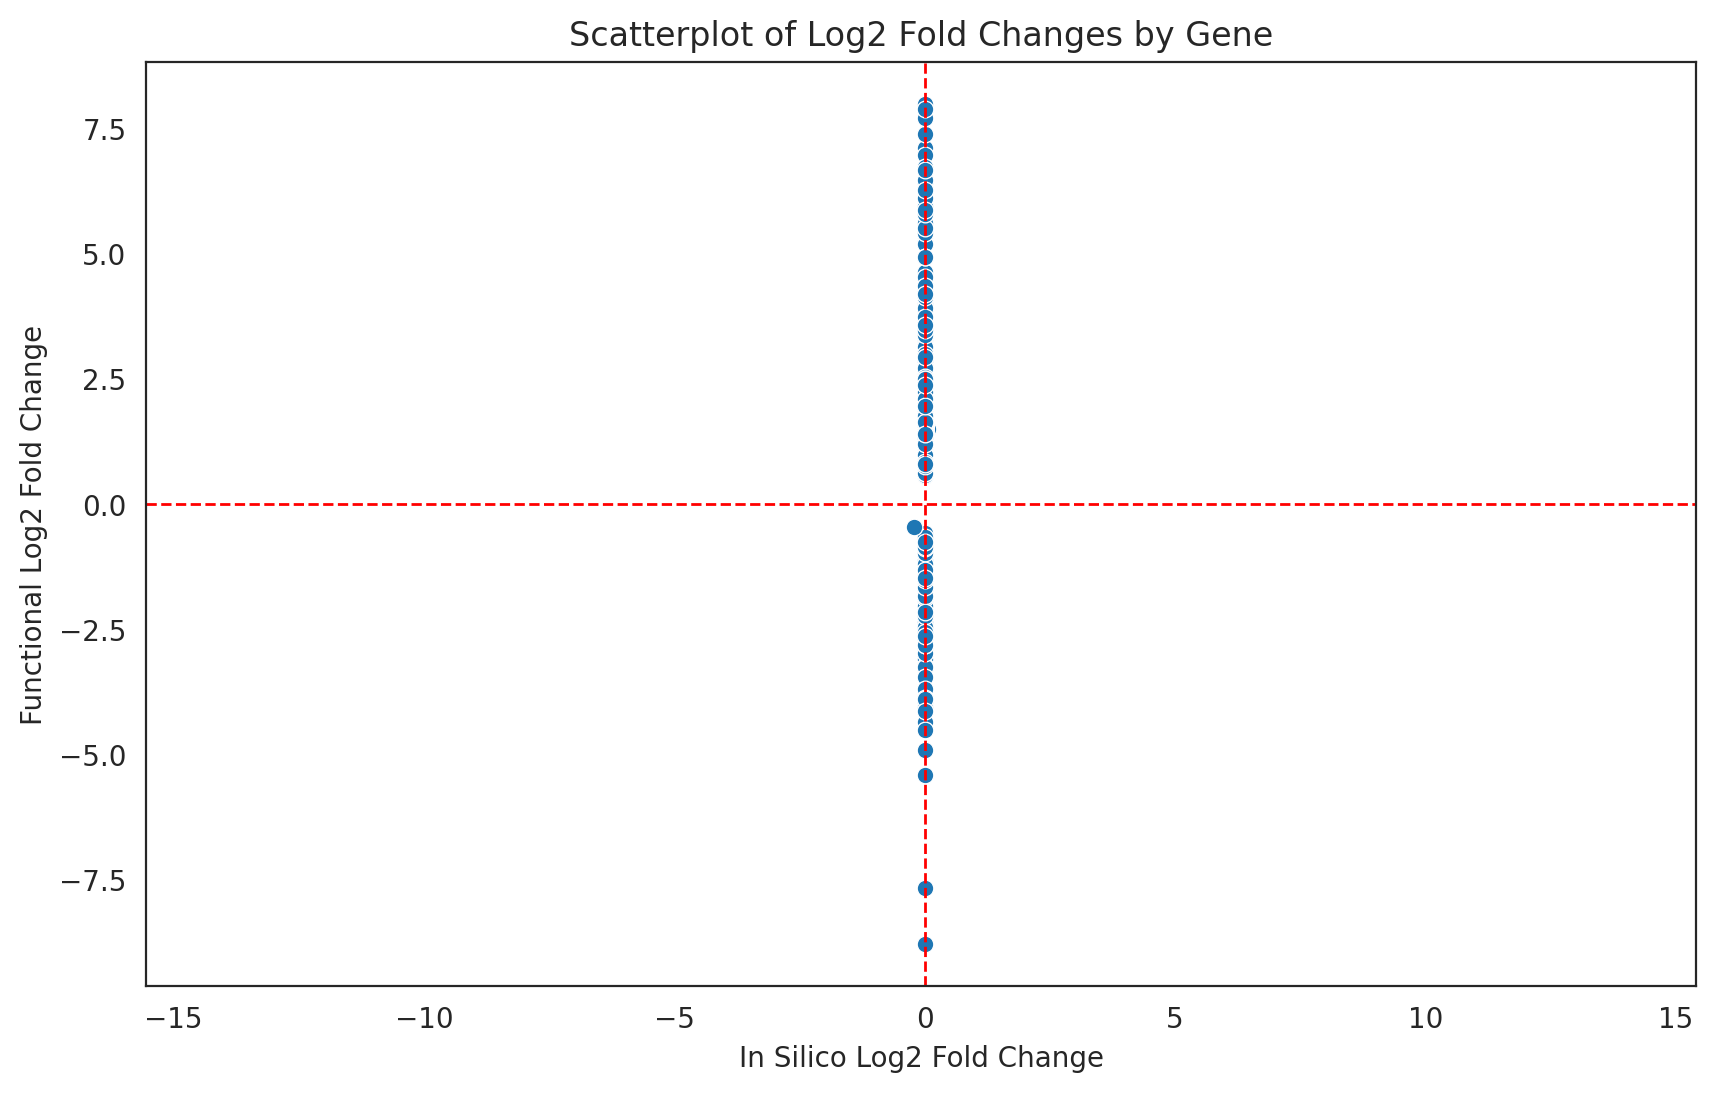

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result, x='Treatment_Log2_Fold_Change', y='logFC')

"""
for i in range(1, len(result)):
    x_val = result['Control_Log2_Fold_Change'][i]
    y_val = result['logFC'][i]
    if abs(x_val) > 1 or abs(y_val) > 1:
        plt.text(
            x_val, 
            y_val, 
            result['Gene'][i],
            fontsize=9,
            ha='right'  # horizontal alignment
        )
"""

# Add labels and title
plt.xlabel('In Silico Log2 Fold Change')
plt.ylabel('Functional Log2 Fold Change')
plt.xticks()
plt.yticks()
plt.title('Scatterplot of Log2 Fold Changes by Gene')

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axis('equal')


# Display the plot
plt.show()

In [16]:
result

,Gene,Treatment_Fold_Change,Treatment_Log2_Fold_Change,logFC,logCPM,LR,PValue,padj
0,Stxbp6,1.040894,0.057822,1.498334,5.597080,0.663198,0.415433,0.999996
1,Usp25,1.000151,0.000218,2.931080,5.800306,3.156435,0.075628,0.999996
2,Trpc5,1.000146,0.000211,0.614347,6.221246,0.442164,0.506080,0.999996
3,Man1a,1.000126,0.000181,2.101492,6.176866,4.057693,0.043971,0.999996
4,Gpc4,1.000101,0.000146,-1.535404,5.933277,1.704272,0.191730,0.999996
...,...,...,...,...,...,...,...,...
850,A530058N18Rik,0.999995,-0.000007,1.971750,5.092569,2.046543,0.152552,0.999996
851,Calb2,0.999995,-0.000008,-0.844411,5.462189,0.245977,0.619922,0.999996
852,Etl4,0.999958,-0.000061,1.397697,6.135740,1.819677,0.177352,0.999996
853,Rps6ka5,0.999949,-0.000074,-0.742078,6.170413,0.651988,0.419403,0.999996


In [17]:
result["Gene"]

0             Stxbp6
1              Usp25
2              Trpc5
3              Man1a
4               Gpc4
           ...      
850    A530058N18Rik
851            Calb2
852             Etl4
853          Rps6ka5
854             Tbr1
Name: Gene, Length: 855, dtype: object

In [20]:
gene_list = ' '.join(result["Gene"].astype(str).tolist())


In [21]:
with open('gene_list.txt', 'w') as f:
    f.write(gene_list)